In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

<Axes: title={'center': 'All-Transactions House Price Index for California'}, xlabel='time', ylabel='Index value'>

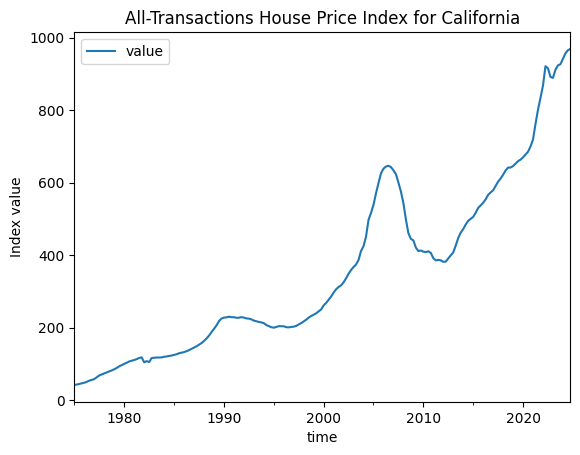

In [3]:
import os

df = pd.read_csv(os.path.join('..', 'Datasets', 'CASTHPI.csv'))
df.rename(columns={'observation_date': 'date', 'CASTHPI': 'value'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype('float32')
df.set_index('date', inplace=True)

df.plot(
    xlabel='time',
    ylabel='Index value',
    title='All-Transactions House Price Index for California',
)

In [4]:
df.head()

,value
date,
1975-01-01,41.689999
1975-04-01,42.770000
1975-07-01,44.349998
1975-10-01,45.779999
1976-01-01,47.820000


In [5]:
data = df["value"]
data.index = data.index.to_period("Q")
adf_test = adfuller(data)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.396083
p-value: 0.981348


Wniosek: nie można założyć że dane są stacjonarne -> d > 0

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

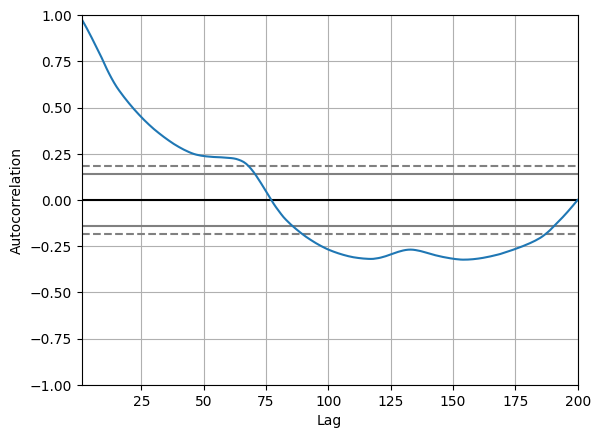

In [6]:
# plot_acf(data, lags=100)
# plot_pacf(data, lags=100)

# plt.figure()
autocorrelation_plot(data)

Wniosek: p = ~10-50

/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  200
Model:                ARIMA(20, 1, 3)   Log Likelihood                -660.859
Date:                Sun, 06 Apr 2025   AIC                           1369.719
Time:                        00:02:09   BIC                           1448.758
Sample:                    03-31-1975   HQIC                          1401.708
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1144      1.698      0.656      0.512      -2.213       4.442
ar.L2         -0.8053      0.404     -1.992      0.046      -1.598      -0.013
ar.L3          1.4293      1.026      1.393      0.1

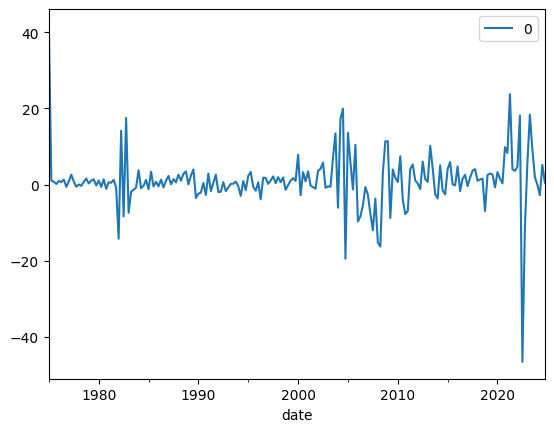

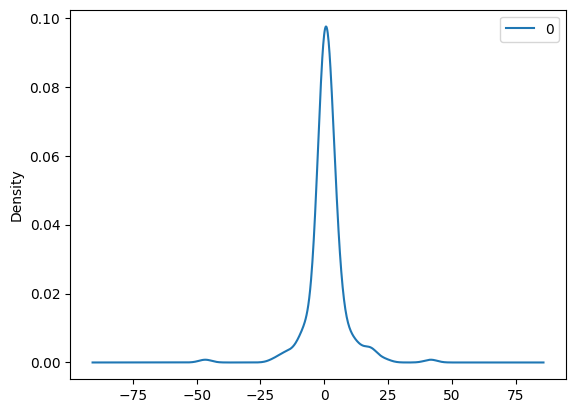

                0
count  200.000000
mean     1.049344
std      7.186757
min    -46.604720
25%     -0.802619
50%      0.723426
75%      2.903916
max     41.689999


In [7]:
model = ARIMA(data, order=(20,1,3))
model_fit = model.fit()
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Rolling forecast

In [8]:
size = int(len(data) * 0.67)
train, test = data[:size], data[size:]

In [ ]:
from typing import Tuple

def fit_predict_ARIMA(n_steps_ahead: int, train: pd.Series, test: pd.Series, order: Tuple[int, int, int]) -> Tuple[pd.Series, pd.Series]:
    history = train.copy()
    predictions = []
    for t in range(0, len(test), n_steps_ahead):
        print(f"step={t//n_steps_ahead}/{len(test)//n_steps_ahead}")
        model = ARIMA(list(history), order=order)
        model_fit = model.fit()
        remaining = len(test) - t
        if remaining < n_steps_ahead:
            n_steps_ahead = remaining
        yhat = model_fit.forecast(steps=n_steps_ahead)
        predictions.extend(yhat)
        obs = test[t : t + n_steps_ahead]
        history = pd.concat([history, obs])

    predictions = pd.Series(predictions, index=test.index[:len(predictions)])
    return predictions, history

In [10]:
def evaluate_ARIMA(predictions, test):
    return mean_absolute_percentage_error(test, predictions)


def plot_ARIMA(predictions, history, n_steps_ahead):
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    plt.title("ARIMA Forecast")
    plt.xlabel("time")
    plt.ylabel("Index value")
    history.plot(color="g", label="true")
    plt.vlines(
        x=predictions.index[0::n_steps_ahead],
        ymin=min(history.min(), predictions.min()),
        ymax=max(history.max(), predictions.max()),
        linestyles="dashed",
    )
    predictions.plot(color="r", label="pred")
    plt.legend()
    plt.show()

In [22]:
predictions, history = fit_predict_ARIMA(4, train, test, (23, 2, 4))
evaluate_ARIMA(predictions, test)

/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env/lib/python3.13/site-packages/statsmodels/base/mod

0.04472868607337814

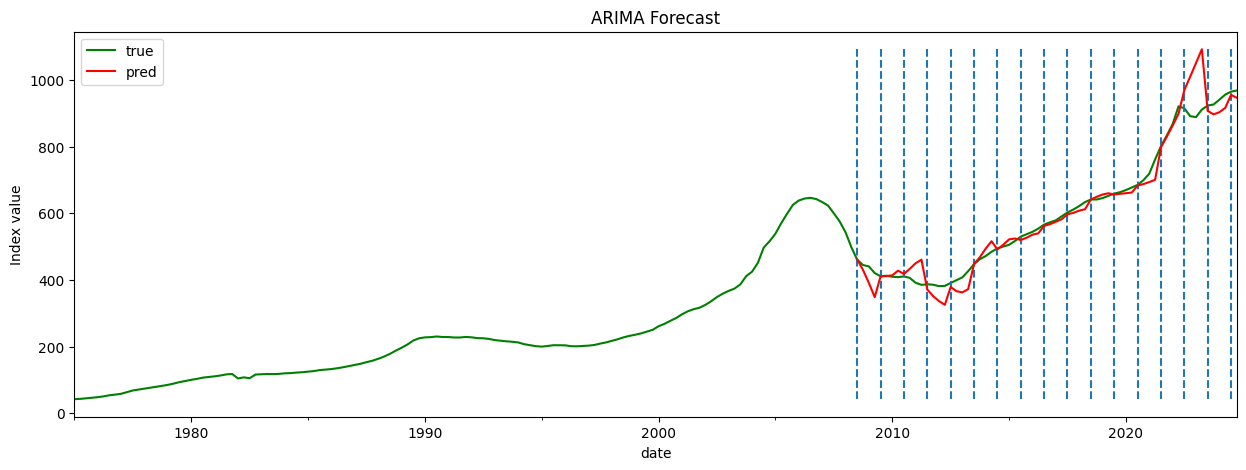

In [23]:
plot_ARIMA(predictions, history, 4)

In [13]:
import random

p_params = random.sample(range(5, 50), 8)
d_params = random.sample(range(1, 10), 4)
q_params = random.sample(range(0, 10), 5)
print(f"p_params: {p_params}")
print(f"d_params: {d_params}")
print(f"q_params: {q_params}")

n_steps_ahead = 8
scores = {}
for p in p_params:
    for d in d_params:
        for q in q_params:
            try:
                print(f"Trying ARIMA({p}, {d}, {q})")
                predictions, history = fit_predict_ARIMA(n_steps_ahead, train, test, (p, d, q))
                score = evaluate_ARIMA(predictions, test)
                scores[(p, d, q)] = score
                print(f"Score: {score}")
            except Exception as e:
                print(f"Error: {e}")

p_params: [44, 39, 38, 43, 48, 46, 27, 18]
d_params: [7, 9, 4, 8]
q_params: [8, 1, 6, 9, 7]
Trying ARIMA(44, 7, 8)


/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/rynowak/Dokumenty/Programy/EksploracjaDanych/EksploracjaDanych/env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

In [ ]:
scores

In [ ]:
best_score = min(scores.values())
best_params = [k for k, v in scores.items() if v == best_score]
print(f"Best score: {best_score}")
print(f"Best params: {best_params}")

In [ ]:
predictions, history = fit_predict_ARIMA(n_steps_ahead, train, test, order=best_params[0])
plot_ARIMA(predictions, history, n_steps_ahead)

## AutoARIMA [TODO]

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [ ]:
autoarima_df = pd.DataFrame()
autoarima_df.head()

""


In [ ]:
autoarima_df["ds"] = df.index
autoarima_df["y"] = df["value"].values
autoarima_df["unique_id"] = "1"
print(autoarima_df.dtypes)
autoarima_df.head()


ds           datetime64[ns]
y                   float32
unique_id            object
dtype: object


,ds,y,unique_id
0,1975-01-01,41.689999,1
1,1975-04-01,42.770000,1
2,1975-07-01,44.349998,1
3,1975-10-01,45.779999,1
4,1976-01-01,47.820000,1


In [ ]:
size = int(len(autoarima_df) * 0.67)
Y_train_df = autoarima_df[:size] 
Y_test_df = autoarima_df[size:]

In [ ]:
models = [AutoARIMA(seasonal=False)]
sf = StatsForecast(models=models, freq='Q')
sf.fit(df=Y_train_df)
arima_string(sf.fitted_[0,0].model_)

'ARIMA(2,1,0)                   '